## Notebook 10.7 
## Assignment notebook by nehasavant

### 1. Generate data into a dataframe called data using numpy and pandas. Your data must be different from what was used in the examples already. Choose different parameters. The intention here is that you will test how changing parameters changes the results. Play around with trying out several different values.

I will be building a probabilistic poission regression. The response variable will be number of individual salamanders found (poisson distribution). The two predictor variables will be presence/absenece of limestone (binomial distribution) and if the species was detected in 1970s or not (binomial distribution). I will be using code from the example in the PyMC3 documentation. 

In [1]:
## Interactive magics
%matplotlib inline
import sys
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
import patsy as pt
import pymc3 as pm

/Users/nehasavant/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#Run local functions included in the PyMc3 documentation. These would will be used primarily to visualize the data.

def strip_derived_rvs(rvs):
    '''Convenience fn: remove PyMC3-generated RVs from a list'''
    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs


def plot_traces_pymc(trcs, varnames=None):
    ''' Convenience fn: plot traces with overlaid means and values '''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in
                             pm.summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')

In [3]:
# decide poisson theta values. These values must be positive, greater than 0. 
theta_lime_yes = 17    # limestone, 1970 presence
theta_nolime_no = 3      # no limestone, 1970 presence
theta_lime_yes = 9  # limestone, no 1970 presence
theta_lime_no = 32   # no limestone, no 1970 presence

# create samples
q = 1000 
df = pd.DataFrame({
        'salanum': np.concatenate((np.random.poisson(theta_lime_yes, q),
                                   np.random.poisson(theta_nolime_no, q),
                                   np.random.poisson(theta_lime_yes, q),
                                   np.random.poisson(theta_lime_no, q))),
        'limestone': np.concatenate((np.repeat(False, q),
                                   np.repeat(True, q),
                                   np.repeat(False, q),
                                   np.repeat(True, q))),
        'oldpres': np.concatenate((np.repeat(False, q),
                                      np.repeat(False, q),
                                      np.repeat(True, q),
                                      np.repeat(True, q)))})

In [4]:
df.tail()

,limestone,oldpres,pres_abs
3995,True,True,40
3996,True,True,31
3997,True,True,35
3998,True,True,41
3999,True,True,35


In [5]:
df.groupby(['oldpres','limestone']).mean().unstack() #View means of the various combinations (mean Poisson values)

pres_abs        
limestone    False   True 
oldpres                   
False        8.992   2.997
True         9.030  32.116

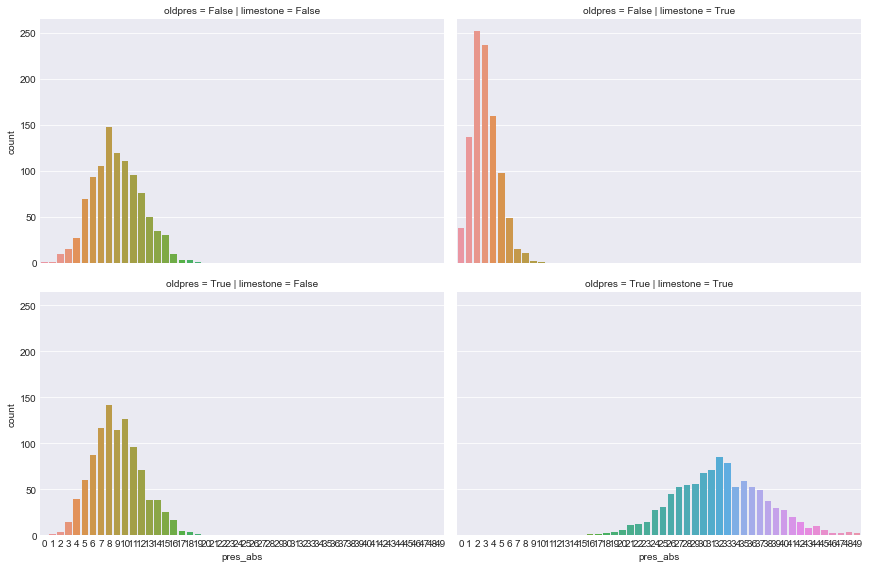

In [6]:
g = sns.factorplot(x='pres_abs', row='oldpres', col='limestone', data=df,
               kind='count', size=4, aspect=1.5)

### 2. Implement a model that is appropriate for the data you have simulated. This can be a simple regression model like in notebook 10.4, or a more complex one like in notebook 10.6. Choose something that is interesting to you.



In [7]:
fml = 'pres_abs ~ oldpres + limestone + oldpres:limestone'  # full patsy formulation for a linear model of the interaction of the terms

In [8]:
#Create a model using pymc3
with pm.Model() as presence_model:
    pm.glm.GLM.from_formula(fml, df, family=pm.glm.families.Poisson())

### 3. Fit your model, plot the trace, and print the summary.

In [9]:
#Sample model
with presence_model:
    trace = pm.sample(4000, tune=2000)[2000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/nehasavant/miniconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log__, oldpres[T.True]:limestone[T.True], limestone[T.True], oldpres[T.True], Intercept]
100%|██████████| 6000/6000 [00:35<00:00, 170.40it/s]


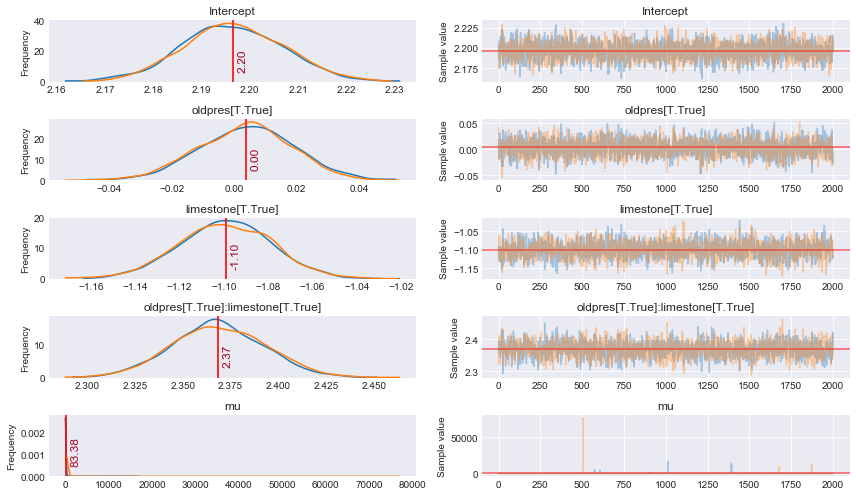

In [10]:
#Plotting the trace
rvs_pres = [rv.name for rv in strip_derived_rvs(presence_model.unobserved_RVs)]
plot_traces_pymc(trace, varnames=rvs_pres)

### 4. Using markdown, describe how closely your model predicted your generative parameters. Are your parameters within the 95% HPD interval? Do you think you ran the MCMC sampler long enough? Do you think anything went wrong? If so, what did you try to troubleshoot the problem? Did you seek help or answers?

In [15]:
df['pres_abs'].mean()

13.28375

In [13]:
np.percentile(trace['mu'], [25,50,75])

array([ 3.98732687,  9.53912735, 22.79917434])

In [11]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,2.196515,0.010422,0.000273,2.175780,2.216436,1109.0,1.000238
oldpres[T.True],0.003726,0.015025,0.000396,-0.024821,0.033216,1120.0,1.001284
limestone[T.True],-1.099229,0.021146,0.000572,-1.138809,-1.055689,1327.0,0.999905
oldpres[T.True]:limestone[T.True],2.368314,0.024175,0.000697,2.321208,2.415170,1137.0,1.000152
mu,83.384652,1390.280743,28.843563,0.002666,119.876671,2264.0,0.999775


The HPD intervals are fairly small, which is good. However, for this specific system, I'm not sure if this model was the correct one to use as the numbers are much higher than we would expect in general. I think that the MCMC sampler was run long enough. But I'm not as sure about the theta values I set when creating the values. 